In [4]:
pip install keras-tuner

Reloading Tuner from my_dir/cnn_hyperparam_tuning/tuner0.json
Epoch 1/50
29/29 [==============================] - 2s 15ms/step - loss: 20.7628 - accuracy: 0.4040 - val_loss: 20.7803 - val_accuracy: 0.4041
Epoch 2/50
29/29 [==============================] - 0s 7ms/step - loss: 20.8199 - accuracy: 0.4173 - val_loss: 20.3898 - val_accuracy: 0.4352
Epoch 3/50
29/29 [==============================] - 0s 7ms/step - loss: 20.9147 - accuracy: 0.4573 - val_loss: 20.1678 - val_accuracy: 0.4508
Epoch 4/50
29/29 [==============================] - 0s 9ms/step - loss: 20.3029 - accuracy: 0.5039 - val_loss: 19.5373 - val_accuracy: 0.5285
Epoch 5/50
29/29 [==============================] - 0s 7ms/step - loss: 20.0580 - accuracy: 0.5427 - val_loss: 22.6469 - val_accuracy: 0.5285
Epoch 6/50
29/29 [==============================] - 0s 9ms/step - loss: 20.1237 - accuracy: 0.5760 - val_loss: 19.6046 - val_accuracy: 0.5389
Epoch 7/50
29/29 [==============================] - 0s 7ms/step - loss: 19.8943 - acc

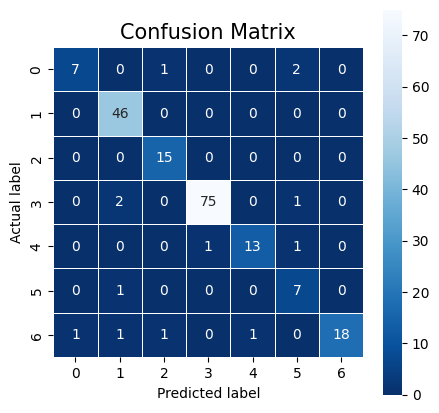

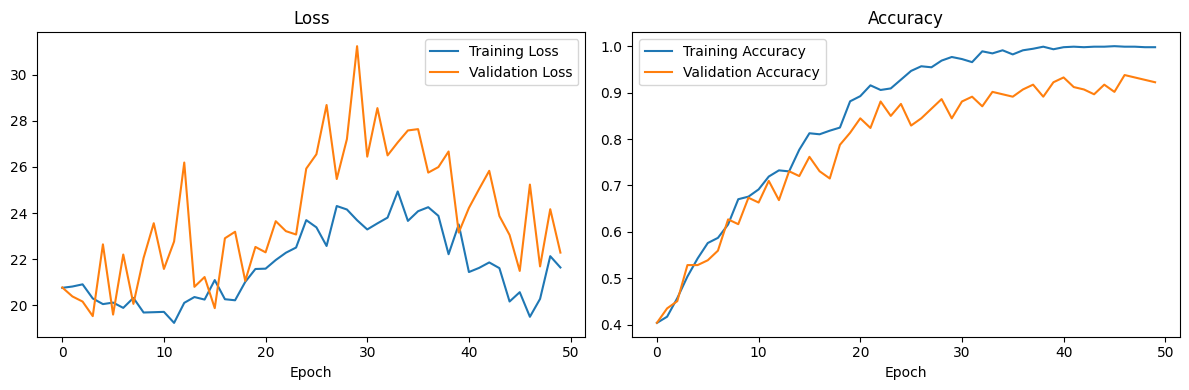

Classification Report:
                    precision    recall  f1-score   support

     Ariel Sharon       0.88      0.70      0.78        10
     Colin Powell       0.92      1.00      0.96        46
  Donald Rumsfeld       0.88      1.00      0.94        15
    George W Bush       0.99      0.96      0.97        78
Gerhard Schroeder       0.93      0.87      0.90        15
      Hugo Chavez       0.64      0.88      0.74         8
       Tony Blair       1.00      0.82      0.90        22

         accuracy                           0.93       194
        macro avg       0.89      0.89      0.88       194
     weighted avg       0.94      0.93      0.93       194



In [23]:
import tensorflow as tf
import math
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import OneHotEncoder

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_val = X_val.reshape(X_val.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)

num_classes = len(np.unique(y_test))
input_shape = X_train.shape[1:]

# Convert labels to one-hot encoded format
encoder = OneHotEncoder(categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_onehot = encoder.transform(y_val.reshape(-1, 1)).toarray()
y_test_onehot = encoder.transform(y_test.reshape(-1, 1)).toarray()

# AM-Softmax Loss
def am_softmax_loss(margin= 0.30, scale=45):
    def loss(y_true, y_pred):
        M = math.e**margin
        y_true = tf.cast(y_true, tf.float32) + margin
        y_pred = y_true * (y_pred - margin)/M + (1 - y_true) * y_pred
        y_pred *= scale
        y_pred = y_pred - margin
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return loss


def build_model(hp):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(),
        loss=am_softmax_loss(),
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='my_dir',
    project_name='cnn_hyperparam_tuning'
)

tuner.search(X_train, y_train_onehot, epochs=10, validation_data=(X_val, y_val_onehot))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)
best_cnn_history =best_model.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot))

best_model.summary()
best_cnn_model = best_model

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy}")

# Use the best model for face recognition
y_pred = best_cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_onehot = np.eye(n_classes)[y_test]
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Use the best model for face recognition
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size=15)# Classification report
#print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=target_names))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history['loss'], label='Training Loss')
plt.plot(best_cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=target_names))





Reloading Tuner from my_dir/cnn_hyperparam_tuning/tuner0.json
Epoch 1/50
29/29 [==============================] - 2s 14ms/step - loss: 15.4454 - accuracy: 0.3796 - val_loss: 15.1918 - val_accuracy: 0.4404
Epoch 2/50
29/29 [==============================] - 0s 7ms/step - loss: 15.3511 - accuracy: 0.3996 - val_loss: 14.9452 - val_accuracy: 0.4404
Epoch 3/50
29/29 [==============================] - 0s 7ms/step - loss: 15.1896 - accuracy: 0.4018 - val_loss: 14.8736 - val_accuracy: 0.4404
Epoch 4/50
29/29 [==============================] - 0s 8ms/step - loss: 14.1882 - accuracy: 0.4428 - val_loss: 12.2624 - val_accuracy: 0.5285
Epoch 5/50
29/29 [==============================] - 0s 8ms/step - loss: 12.7001 - accuracy: 0.5161 - val_loss: 11.9666 - val_accuracy: 0.5130
Epoch 6/50
29/29 [==============================] - 0s 8ms/step - loss: 12.2672 - accuracy: 0.5172 - val_loss: 11.5489 - val_accuracy: 0.5492
Epoch 7/50
29/29 [==============================] - 0s 7ms/step - loss: 11.1192 - acc

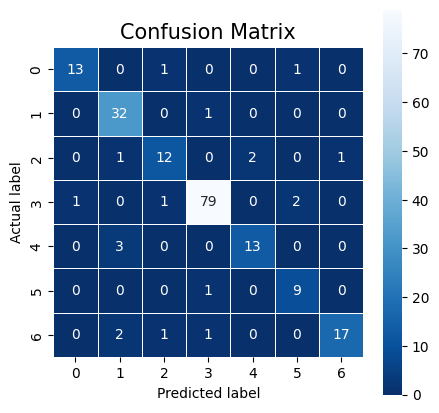

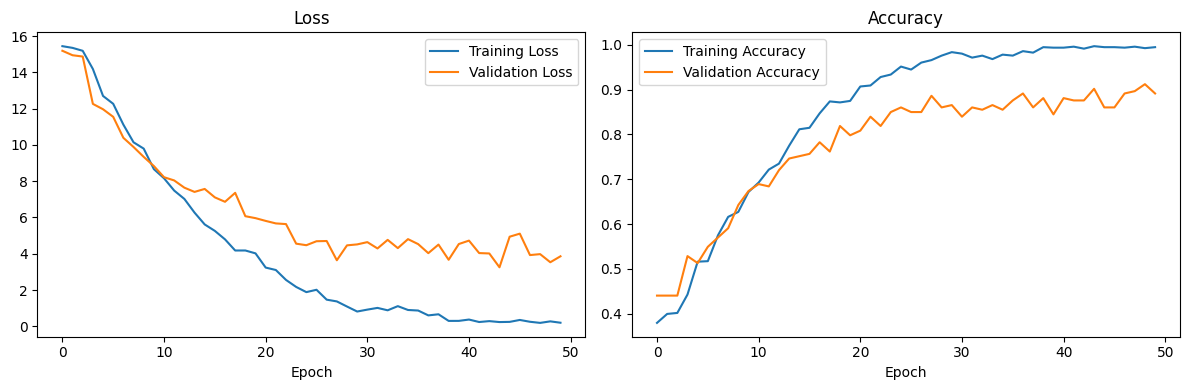

Classification Report:
                    precision    recall  f1-score   support

     Ariel Sharon       0.93      0.87      0.90        15
     Colin Powell       0.84      0.97      0.90        33
  Donald Rumsfeld       0.80      0.75      0.77        16
    George W Bush       0.96      0.95      0.96        83
Gerhard Schroeder       0.87      0.81      0.84        16
      Hugo Chavez       0.75      0.90      0.82        10
       Tony Blair       0.94      0.81      0.87        21

         accuracy                           0.90       194
        macro avg       0.87      0.87      0.87       194
     weighted avg       0.91      0.90      0.90       194



In [6]:
import tensorflow as tf
import math
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import OneHotEncoder

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_val = X_val.reshape(X_val.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)

num_classes = len(np.unique(y_test))
input_shape = X_train.shape[1:]

# Convert labels to one-hot encoded format
encoder = OneHotEncoder(categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_onehot = encoder.transform(y_val.reshape(-1, 1)).toarray()
y_test_onehot = encoder.transform(y_test.reshape(-1, 1)).toarray()

# AM-Softmax Loss
def am_softmax_loss(margin=0.35, scale=40.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = y_true * (y_pred - margin) + (1 - y_true) * y_pred
        y_pred *= scale
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return loss

def build_model(hp):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(),
        loss=am_softmax_loss(),
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='my_dir',
    project_name='cnn_hyperparam_tuning'
)

tuner.search(X_train, y_train_onehot, epochs=10, validation_data=(X_val, y_val_onehot))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)
best_cnn_history =best_model.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot))

best_model.summary()
best_cnn_model = best_model

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy}")

# Use the best model for face recognition
y_pred = best_cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_onehot = np.eye(n_classes)[y_test]
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Use the best model for face recognition
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size=15)# Classification report
#print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=target_names))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history['loss'], label='Training Loss')
plt.plot(best_cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=target_names))



